# CPC Speech usage examples

## Extract speech embeddings

In [18]:
import sys
sys.path.append('cpcspeech/src/cpcspeech')
import cpcspeech
import h5py
import numpy as np
from sklearn.manifold import TSNE

In [19]:
data_path = 'data/processed/librispeech_valid.hdf5'
sample_data = h5py.File(data_path, 'r')
seq_len = 20480
X = np.array([sample_data[k][:seq_len] for k in list(sample_data.keys())])
X = X[:,np.newaxis,:]

In [20]:
model_path = './workstation/contrastive_predictive_coding/trained_models/cpc_test_model_2020-10-06-11-04-37'
cpc = cpc_speech.CPC_speech()
cpc.load_pretrained_model(model_path)

In [21]:
speech_emb = cpc.transform(X)
# spk_lbl = 

In [ ]:
tsne_spk_emb = TSNE(n_components=2).fit_transform(speech_emb)
plt.scatter(tsne_spk_emb[:,0],tsne_spk_emb[:,1],c=spk_lbl)

## Preprocess dataset

In [ ]:
import sys
sys.path.append('cpc_speech/src/cpc_speech')
from data import LibriSpeech100_preprocessing

In [ ]:
# data_path = '/home/giovanni.maffei/datasets/librispeech/LibriSpeech/train-clean-100/'
data_path = '../../datasets/libri_speech/LibriSpeech/train-clean-100/'
split_path = 'data/labels_split/'
processed_data_path = 'data/processed/'
seq_len = 20480

train_file_list_path = split_path+'train_split.txt'
valid_file_list_path = split_path+'valid_split.txt'
# test_file_list_path  = '/home/giovanni.maffei/datasets/librispeech/oord_label_split/test_split.txt'

train_output_path = processed_data_path+'librispeech_train.hdf5'
valid_output_path = processed_data_path+'librispeech_valid.hdf5'
# test_output_path  = processed_data_path+'librispeech_test.hdf5'

In [ ]:
LibriSpeech100_preprocessing(train_file_list_path, data_path, train_output_path, seq_len)
LibriSpeech100_preprocessing(valid_file_list_path, data_path, valid_output_path, seq_len)

## CPC training

In [ ]:
import sys
sys.path.append('cpc_speech/src/cpc_speech')
import cpc_speech

In [4]:
cpc = cpc_speech.CPC_speech()

In [5]:
train_path = 'data/processed/librispeech_train.hdf5'
valid_path = 'data/processed/librispeech_valid.hdf5'
cpc.load_train_data(train_path, valid_path)

In [11]:
cpc.train(100,lr=0.01, plot=True)

In [7]:
save_model_folder = 'trained_models/'
cpc.save_model(save_model_folder)

## Speaker classification with CPC embeddings

In [4]:
from models import MLP#, CPC
from data import LibriSpeech100_dataset_spk_class
from train import Spk_Training
import cpc_speech
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [5]:
device_type = 'cpu'
# device_type = 'cuda'
device = torch.device(device_type)

### load dataset

In [8]:
train_path = 'data/processed/librispeech_train.hdf5'
train_path = 'data/processed/librispeech_valid.hdf5'
seq_len = 20480
batch_size = 64

train_spk_data = LibriSpeech100_dataset_spk_class(train_path,seq_len,batch_size)
train_spk_dataloader = DataLoader(train_spk_data, batch_size=batch_size, shuffle=True, num_workers=0)

valid_spk_data = LibriSpeech100_dataset_spk_class(train_path,seq_len,batch_size)
valid_spk_dataloader = DataLoader(valid_spk_data, batch_size=batch_size, shuffle=True, num_workers=0)

### load CPC model

In [6]:
cpc = cpc_speech.CPC_speech()
cpc.load_pretrained_model('workstation/contrastive_predictive_coding/trained_models/cpc_test_model_2020-10-06-11-04-37')
cpc.freeze()
cpc_model = cpc.cpc_model

In [7]:
# seq_len = 20480
# comp_rate = 160
# n_timesteps = 12

# cpc_model = CPC(n_timesteps, seq_len).to(device)
# cpc_model.load_state_dict(torch.load('workstation/contrastive_predictive_coding/trained_models/cpc_test_model_2020-10-06-11-04-37', map_location=device))

# for param in cpc_model.parameters():
#     param.requires_grad = False

### initialize MLP speaker model

In [9]:
n_speakers = len(train_spk_data.unique_spk_ids)
emb_size = 256
inner_size = 512
spk_classifier = MLP(emb_size, inner_size, n_speakers)

### train

In [ ]:
train_params = [p for p in spk_classifier.parameters() if p.requires_grad == True]
optimizer = optim.Adam(train_params, lr=0.0002, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
loss = F.nll_loss

-- epoch 0 --
train loss: 0.1045440062880516
valid loss: 0.08936391025781631
best valid loss: 0.08936391025781631
train accuracy: 0.0
valid accuracy: 0.0


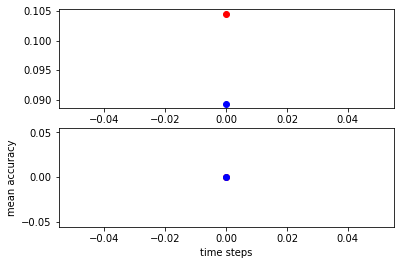

-- epoch 1 --
train loss: 0.10566898435354233
valid loss: 0.08745819330215454
best valid loss: 0.08745819330215454
train accuracy: 0.0
valid accuracy: 0.0


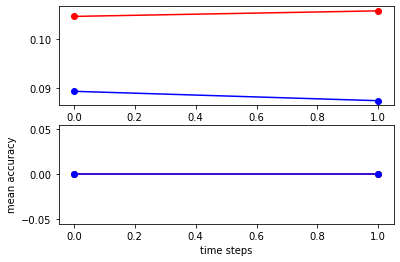

-- epoch 2 --
train loss: 0.10029075294733047
valid loss: 0.0860469862818718
best valid loss: 0.0860469862818718
train accuracy: 0.0
valid accuracy: 0.015625


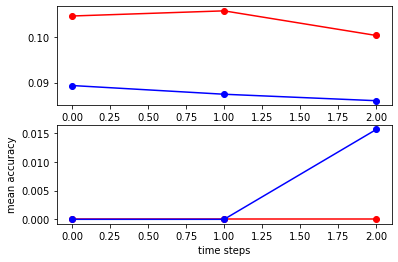

-- epoch 3 --
train loss: 0.10110612213611603
valid loss: 0.08200940489768982
best valid loss: 0.08200940489768982
train accuracy: 0.00048828125
valid accuracy: 0.015625


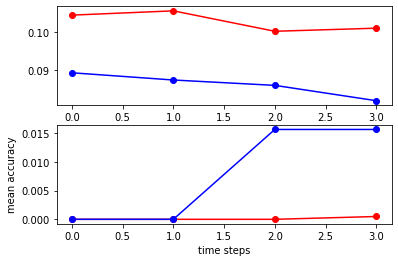

-- epoch 4 --
train loss: 0.09875445067882538
valid loss: 0.08007921278476715
best valid loss: 0.08007921278476715
train accuracy: 0.0
valid accuracy: 0.015625


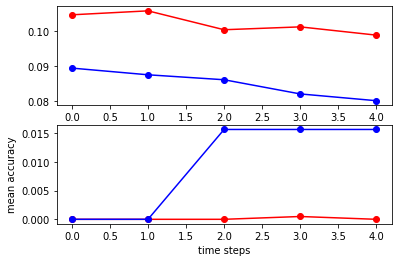

In [9]:
n_epochs = 5
spk_training = Spk_Training(cpc_model, spk_classifier, loss, optimizer, train_spk_dataloader, valid_spk_dataloader, device)
spk_training.train(n_epochs, plot=True)